In [1]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

#### add lp_mass 16-84 range in trimed C20_classic catalog

In [ ]:
# add lp_mass 16-84 range
cat_1 = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_added.fits')
cat_2 = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits')
if 'lp_mass_med_min68' not in cat_1.keys():
    cat_1.add_column(cat_2['lp_mass_med_min68'])
    cat_1.add_column(cat_2['lp_mass_med_max68'])
    cat_1.write('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_added.fits',overwrite=True)

#### compare C20 mass internally

In [2]:
# convert ez mass to log scale
cat_c20_check = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlymassphotoz_v2.0.fits')
col_log_ezmass_1 = Column(name='log_ez_mass_1', data=np.log10(cat_c20_check['ez_mass_p500_1']),dtype='f8')
col_log_ezmass_2 = Column(name='log_ez_mass_2', data=np.log10(cat_c20_check['ez_mass_p500_2']),dtype='f8')

if 'log_ez_mass_1' in cat_c20_check.keys():
    cat_c20_check.remove_columns(['log_ez_mass_1','log_ez_mass_2'])
cat_c20_check.add_columns([col_log_ezmass_1,col_log_ezmass_2])
cat_c20_check.write('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlymassphotoz_v2.0.fits', overwrite=True)

In [7]:
# check internal consistency of C20 redshifts
# 1=classic 2=farmer

cat_c20_check = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlymassphotoz_v2.0.fits')

factor = 0.15
lp1_lp2_cond = abs(cat_c20_check['lp_zPDF_1'] - cat_c20_check['lp_zPDF_2']) < factor*(1+cat_c20_check['lp_zPDF_1'])
lp1_ez1_cond = abs(cat_c20_check['lp_zPDF_1'] - cat_c20_check['ez_z500_1']) < factor*(1+cat_c20_check['lp_zPDF_1'])
lp1_ez2_cond = abs(cat_c20_check['lp_zPDF_1'] - cat_c20_check['ez_z500_2']) < factor*(1+cat_c20_check['lp_zPDF_1'])
lp2_ez1_cond = abs(cat_c20_check['lp_zPDF_2'] - cat_c20_check['ez_z500_1']) < factor*(1+cat_c20_check['lp_zPDF_2'])
lp2_ez2_cond = abs(cat_c20_check['lp_zPDF_2'] - cat_c20_check['ez_z500_2']) < factor*(1+cat_c20_check['lp_zPDF_2'])
ez1_ez2_cond = abs(cat_c20_check['ez_z500_1'] - cat_c20_check['ez_z500_2']) < factor*(1+cat_c20_check['ez_z500_1'])

flag_matched = np.array(np.isnan(cat_c20_check['lp_zPDF_2'])).astype(int)*-99
flag_goodz = np.array(lp1_lp2_cond*lp1_ez1_cond*lp1_ez2_cond*lp2_ez1_cond*lp2_ez2_cond*ez1_ez2_cond).astype(int)
flag_photoz_c20 = flag_matched + flag_goodz # 0=bad-z, 1=good-z, -99=not matched
print('++++++++++++++++')
print('bad z:',len(flag_photoz_c20[flag_photoz_c20==0]))
print('good z:',len(flag_photoz_c20[flag_photoz_c20==1]))
print('not matched:',len(flag_photoz_c20[flag_photoz_c20==-99]))

factor = 0.3

# convert ez mass to log scale
lp1_lp2_cond = abs(cat_c20_check['lp_mass_med_1'] - cat_c20_check['lp_mass_med_2']) < factor
lp1_ez1_cond = abs(cat_c20_check['lp_mass_med_1'] - cat_c20_check['log_ez_mass_1']) < factor
lp1_ez2_cond = abs(cat_c20_check['lp_mass_med_1'] - cat_c20_check['log_ez_mass_2']) < factor
lp2_ez1_cond = abs(cat_c20_check['lp_mass_med_2'] - cat_c20_check['log_ez_mass_1']) < factor
lp2_ez2_cond = abs(cat_c20_check['lp_mass_med_2'] - cat_c20_check['log_ez_mass_2']) < factor
ez1_ez2_cond = abs(cat_c20_check['log_ez_mass_1'] - cat_c20_check['log_ez_mass_2']) < factor

flag_matched = np.array(np.isnan(cat_c20_check['lp_mass_med_2'])).astype(int)*-99
flag_goodmass = np.array(lp1_lp2_cond*lp1_ez1_cond*lp1_ez2_cond*lp2_ez1_cond*lp2_ez2_cond*ez1_ez2_cond).astype(int)
flag_massmatched_c20 = flag_matched + flag_goodmass # 0=bad-mass, 1=good-mass, -99=not matched
num_of_mass_estimated = np.isnan(cat_c20_check['lp_mass_med_1']).astype(int) + np.isnan(cat_c20_check['lp_mass_med_2']).astype(int) + np.isnan(cat_c20_check['log_ez_mass_1']).astype(int) + np.isnan(cat_c20_check['log_ez_mass_2']).astype(int)

print(len(np.isnan(cat_c20_check['lp_mass_med_1']).astype(int)),len(num_of_mass_estimated))
arr=np.transpose(np.vstack([np.array(cat_c20_check['lp_mass_med_1']), np.array(cat_c20_check['lp_mass_med_2']), np.array(cat_c20_check['log_ez_mass_1']), np.array(cat_c20_check['log_ez_mass_2'])]))
mass_mean = np.nanmean(arr,axis=1)
mass_scatter = np.nanstd(arr,axis=1,ddof=1)

print('++++++++++++++++')
print('good mass:',len(flag_massmatched_c20[flag_massmatched_c20==0]))
print('bad mass:',len(flag_massmatched_c20[flag_massmatched_c20==1]))
print('not matched:',len(flag_massmatched_c20[flag_massmatched_c20==-99]))
print('all 4 masses estimated:',len(num_of_mass_estimated[num_of_mass_estimated==0]))

# # add column to the original C20 catalog 
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_added.fits'
cat_c20 = Table.read(cat_c20_name)
flag_photoz_col = Column(name='flag_photoz',data=flag_photoz_c20)
flag_massmatched_col = Column(name='flag_mass',data=flag_massmatched_c20)
num_of_mass_col = Column(name='num_of_mass',data=num_of_mass_estimated)
mass_mean_col = Column(name='mass_c20_mean',data=mass_mean)
mass_scatter_col = Column(name='mass_c20_scatter',data=mass_scatter)

for col_name in ['flag_photoz','flag_mass','num_of_mass','mass_c20_mean','mass_c20_scatter']:
    if col_name in cat_c20.keys():
        cat_c20.remove_column(col_name)
    if col_name in cat_c20_check.keys():
        cat_c20_check.remove_column(col_name)
        
cat_c20.add_columns([flag_photoz_col,flag_massmatched_col,num_of_mass_col,mass_mean_col,mass_scatter_col])
cat_c20_check.add_columns([flag_photoz_col,flag_massmatched_col,num_of_mass_col,mass_mean_col,mass_scatter_col])
cat_c20.write(cat_c20_name, overwrite=True)
print('Done')

/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


++++++++++++++++
bad z: 410617
good z: 365708
not matched: 944375
1720700 1720700


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


++++++++++++++++
good mass: 656787
bad mass: 108223
not matched: 955690
all 4 masses estimated: 669694
Done


Text(0, 0.5, 'Mass Scatter')

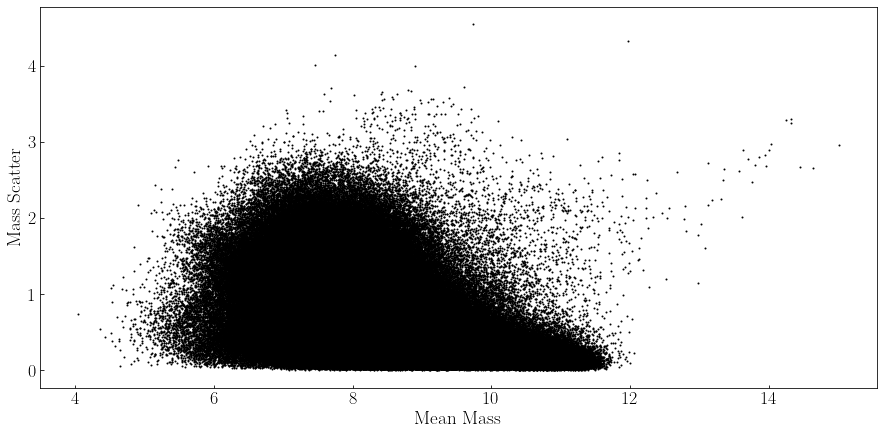

In [8]:
cat_c20_selected = cat_c20_check[cat_c20_check['num_of_mass']==0] # has all four masses
# cat_c20_selected = cat_c20_selected[cat_c20_selected['flag_mass']==1]

fig, axs = plt.subplots(1, 1, figsize = (15, 7),sharex=True, sharey=True)
plt.scatter(cat_c20_selected['mass_c20_mean'],cat_c20_selected['mass_c20_scatter'],s=1,c='k')
plt.xlabel('Mean Mass',fontsize=19)
plt.ylabel('Mass Scatter',fontsize=19)

In [9]:
def percentile_16(arr):
    return np.percentile(arr,16)

def percentile_84(arr):
    return np.percentile(arr,84)

In [10]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
cat_name = output_dir+'cat_out_nonir_il_formass.fits'
cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
cat_output_c20added = cat_output_c20added[cat_output_c20added['MASS_MED_massrun']>0]
cat_output_c20added = cat_output_c20added[cat_output_c20added['flag_photoz']==1]

/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp

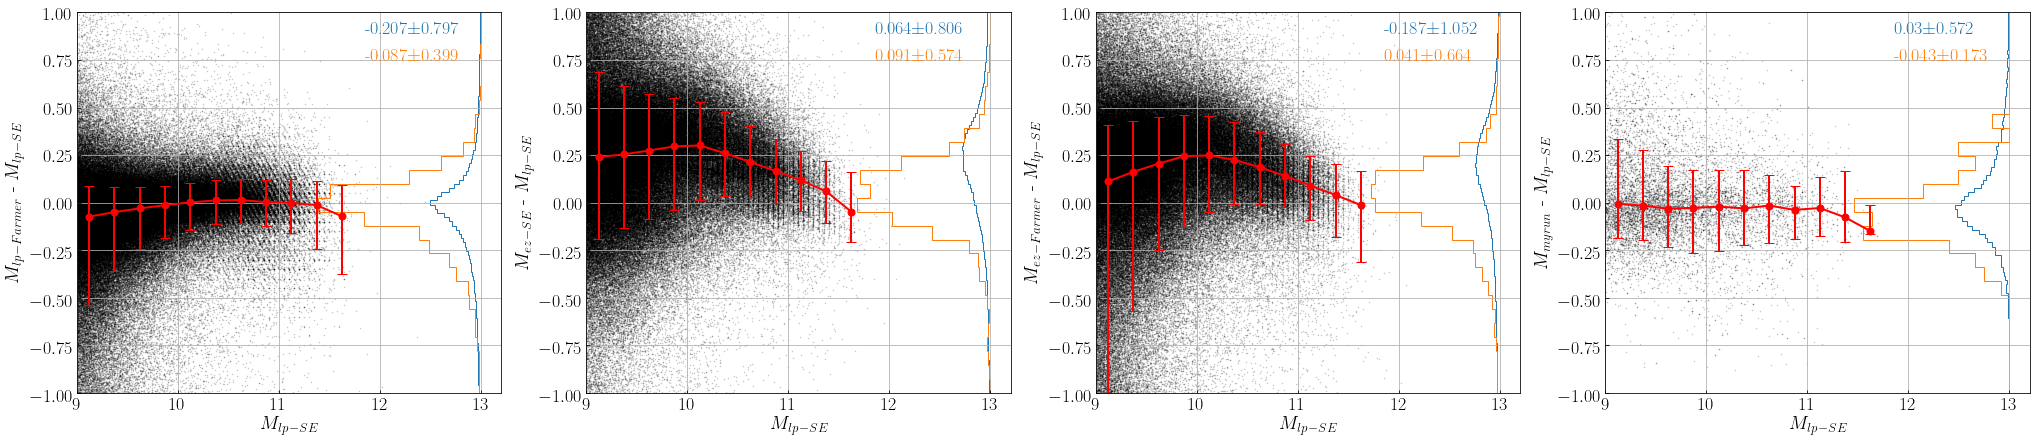

In [16]:
fig, axs = plt.subplots(1, 4, figsize = (35, 7))
y_labels = ['$M_{lp-Farmer}$','$M_{ez-SE}$','$M_{ez-Farmer}$','$M_{myrun}$']
for i,y_mass in enumerate(['lp_mass_med_2','log_ez_mass_1','log_ez_mass_2','m_myrun']):
    if i == 3:
        axs[i].scatter(cat_output_c20added['lp_mass_med'],cat_output_c20added['MASS_MED_massrun']-cat_output_c20added['lp_mass_med'],s=0.3,c='k',alpha=0.2)
    else:
        axs[i].scatter(cat_c20_selected['lp_mass_med_1'],cat_c20_selected[y_mass]-cat_c20_selected['lp_mass_med_1'],s=0.3,c='k',alpha=0.2)
    
    axs[i].set_xlabel(r'$M_{lp-SE}$',fontsize=19)
    axs[i].set_ylabel(y_labels[i]+' - '+'$M_{lp-SE}$',fontsize=19)
    axs[i].set_xlim([9,13.2]) 
    axs[i].set_ylim([-1,1])
    axs[i].grid()

    # running median
    step=0.25
    if i==3:
        x = cat_output_c20added['lp_mass_med']
        y = cat_output_c20added['MASS_MED_massrun']-cat_output_c20added['lp_mass_med']
        y_massive_gal = y[cat_output_c20added['lp_mass_med']>11.2]
    else:
        x=cat_c20_selected['lp_mass_med_1']
        y=cat_c20_selected[y_mass]-cat_c20_selected['lp_mass_med_1']
        y_massive_gal = y[cat_c20_selected['lp_mass_med_1']>11.2]
    
    # statistics
    medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(9,12,step))
    per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(9,12,step))
    per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(9,12,step))
    axs[i].errorbar(bin_edges[:-1]+step/2,medians,yerr=[medians-per16,per84-medians],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
    
    # std error
    axs[i].annotate(str(round(np.nanmean(y),3))+'$\pm$'+str(round(np.nanstd(y),3)),xy=([0.68,0.95]),xycoords='axes fraction',fontsize=  18,color='tab:blue')
    axs[i].annotate(str(round(np.nanmean(y_massive_gal),3))+'$\pm$'+str(round(np.nanstd(y_massive_gal),3)),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='tab:orange')
    
    # histogram for delta_M
    axs[i].hist(y,bins=100,range=(-1,1.2),orientation='horizontal',weights=-10*np.ones(len(y))/len(y),bottom=13,histtype='step')
    axs[i].hist(y_massive_gal,bins=30,range=(-1,1.2),orientation='horizontal',weights=-8*np.ones(len(y_massive_gal))/len(y_massive_gal),bottom=13,histtype='step')

#### add CLASS (sfq classfication) to COSMOS2020 v2.0 catalog

$M_{NUV} - M_r > 3 (M_r -M_J)+1$

$M_{NUV} - M_r>3.1$


In [8]:
cat = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits')

# lp_MNUV, lp_MR, lp_MJ
# 0==q, 1==sf
cond1 = cat['lp_MNUV'] - cat['lp_MR'] < 3*(cat['lp_MR'] - cat['lp_MJ']) + 1
cond2 = cat['lp_MNUV'] - cat['lp_MR'] < 3.1
CLASS = (cond1|cond2).astype(int)

/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [9]:
cat_c20_trimed = Table.read('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_added.fits')

class_col = Column(data=CLASS, name='CLASS')
cat_c20_trimed.add_column(class_col)
cat_c20_trimed.write('/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits', overwrite=True)

#### NUVrK plot with FARMER abs. mags and SExtractor classification
both with abs. magnitudes estimated with LePhare

In [45]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

In [29]:
# match 2 CLASSIC and FARMER original catalogs
# keep only lp abs. mag columns
cat_c20_classic = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits'
cat_c20_farmer = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_FARMER_R1_v2.0.fits'
combined_cat_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlyabsmag_v2.0.fits'
join = 'all1'

# matching cat_output and cat_c20
col_list = "'lp_MNUV_* lp_MR_* lp_MK_* lp_MJ_* lp_zPDF_* lp_mass_med_* HSC_i_MAG_AUTO HSC_i_MAG'"
cmd = 'java -jar stilts.jar tmatch2 in1='+cat_c20_classic + ' in2='+cat_c20_farmer+' find=best join='+join+\
      ' matcher=sky params=0.1 values1="ALPHA_J2000 DELTA_J2000"  values2="ALPHA_J2000 DELTA_J2000" suffix1=_classic suffix2=_farmer out='+\
      combined_cat_name +' ocmd="keepcols '+col_list+'"'
print(cmd)
os.system(cmd)

# # add CLASS info
cat_combined = Table.read(combined_cat_name)
cat_combined.add_column(class_col)
cat_combined.write(combined_cat_name, overwrite=True)

java -jar stilts.jar tmatch2 in1=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits in2=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_FARMER_R1_v2.0.fits find=best join=all1 matcher=sky params=0.1 values1="ALPHA_J2000 DELTA_J2000"  values2="ALPHA_J2000 DELTA_J2000" suffix1=_classic suffix2=_farmer out=/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_FARMER_onlyabsmag_v2.0.fits ocmd="keepcols 'lp_MNUV_* lp_MR_* lp_MK_* lp_MJ_* lp_zPDF_* lp_mass_med_* HSC_i_MAG_AUTO HSC_i_MAG'"


/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


[]

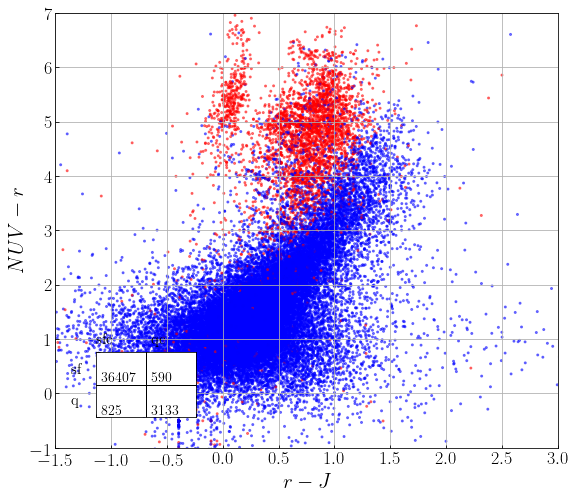

In [48]:
cat = Table.read(combined_cat_name)
cat = cat[cat['lp_zPDF_classic']>0]
cat = cat[cat['lp_mass_med_classic']>6]
cat = cat[cat['HSC_i_MAG_AUTO']>17]
cat = cat[cat['HSC_i_MAG_AUTO']<26]
select_ids = np.random.choice(np.arange(len(cat)), size=100000,replace=False)
cat = cat[select_ids]

suffix='_farmer'
plot_type='J' # K or J

fig, axs = plt.subplots(1, 1, figsize = (9, 8), sharey=True)
plt.scatter(cat['lp_MR'+suffix]-cat['lp_M'+plot_type+suffix], cat['lp_MNUV'+suffix]-cat['lp_MR'+suffix],s=4,c=cat['CLASS'],alpha=0.5,cmap='bwr_r')
plt.xlabel(r'$r-'+plot_type+'$',fontsize=21)
plt.ylabel(r'$NUV-r$',fontsize=21)
plt.xlim([-1.5,3])
plt.ylim([-1,7])
plt.grid()

#### contingency table / confusion matrix (inset plot 2) ######
# q=P sf=N
cat_sf = cat[cat['CLASS']==1]
cat_q = cat[cat['CLASS']==0]
best_box_c20 = [3.1, 1, 3]
 
rj_sf = np.array(cat_sf['lp_MR'+suffix] - cat_sf['lp_M'+plot_type+suffix])
rj_q = np.array(cat_q['lp_MR'+suffix] - cat_q['lp_M'+plot_type+suffix]) 
delta_gv_sf = cat_sf['lp_MNUV'+suffix] - cat_sf['lp_MR'+suffix]-gv_boundary_2(rj_sf,best_box_c20[0],best_box_c20[1],best_box_c20[2])
delta_gv_q = cat_q['lp_MNUV'+suffix] - cat_q['lp_MR'+suffix]-gv_boundary_2(rj_q,best_box_c20[0],best_box_c20[1],best_box_c20[2])

sf_sf = len(cat_sf[delta_gv_sf<0])  # TN
q_q = len(cat_q[delta_gv_q>0])      # TP
sf_q = len(cat_q[delta_gv_q<0])     # FP
q_sf = len(cat_sf[delta_gv_sf>0])   # FN
        
# inset table
plt.annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
plt.annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
plt.annotate('sf',xy=([0.03,0.17]),xycoords='axes fraction',fontsize=15)
plt.annotate('q',xy=([0.03,0.1]),xycoords='axes fraction',fontsize=15)
ax_insert2 = axs.inset_axes([0.08, 0.07, 0.2, 0.15])
ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
ax_insert2.set_xlim([-1,1])
ax_insert2.set_ylim([-1,1])
ax_insert2.set_yticklabels([])
ax_insert2.set_xticklabels([])